In [50]:
# Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, AveragePooling2D, Flatten
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import History
from keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import gzip
import struct
import seaborn as sns

In [51]:
#Filenames
test_images = 't10k-images-idx3-ubyte.gz'
test_labels = 't10k-labels-idx1-ubyte.gz'
train_images = 'train-images-idx3-ubyte.gz'
train_labels = 'train-labels-idx1-ubyte.gz'
file_arr = [test_images, test_labels,train_images,train_labels]

#### File Formats for the MNIST Database

Per the MNIST landing page, the files are in IDX format, which is supposedly an ideal format for compression of vectors and multidimensional matrices. I have not personally written any code up until this point to read through an idx format file, so the code below is a product of online documentation.

##### Image File
The image file contains the pixel input to all of the training and test examples in the MNIST datset. 

- First 4 Bytes: Magic Number -> 3rd byte represents the data type; 4th byte represents the number of dimensions of the matrix/vector (2 in this case)
- Second 4 Bytes: Number of Images
- Third 4 bytes: Number of Rows
- Fourth 4 bytes: Number of Columns
- Rest -> Pixel Data
    - Integer - 1 byte each
    - from 0-255  


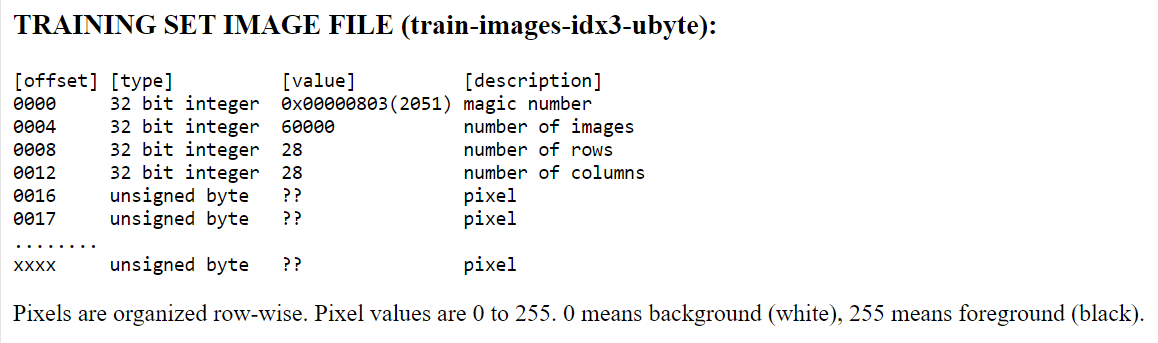


##### Label File
The label file will be a (60000,) populated by the labels of the corresponding image file - matching in index.

- First 4 Bytes: Magic Number -> 3rd byte represents the data type; 4th byte represents the number of dimensions of the matrix/vector (2 in this case)
- Second 4 Bytes: Number of Items
- Rest -> Label Data
    - Integer - 1 byte each
    - from 0-9 

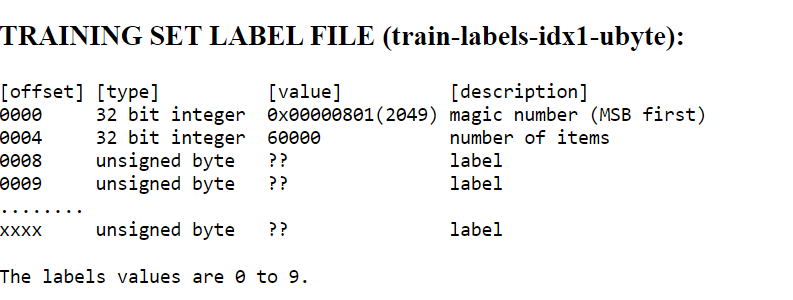


#### Useful Libraries and Functions

##### Struct
Since it is noted in the MNIST dataset landing page that the data is stored in a C array, we needed to use a Python library to convert the contents of the data files into a python interpretable format. 

Using information of the number of bytes per data parameter as well as the data type for each, we are able to extract the necessary information from the file using struct's format strings. 

###### Struct Format Strings
- Magic Number, Rows, Columns, Number of Items are all specified as 32 bit integers -> ">I"
- Pixels, Labels are specified as a single byte integer -> ">B"

">" eludes to the data being formatted in MBS first (high endian) as mentioned in the landing page

In [52]:
# Function to parse MNIST data downloaded from http://yann.lecun.com/exdb/mnist/ 
def load_data(file, type):
    with gzip.open(file, 'rb') as f:
        if type == 'images':
            magic_num, = struct.unpack(">I", f.read(4))
            nimages, = struct.unpack(">I", f.read(4))
            nrows, ncols = struct.unpack(">II", f.read(8))
            totalBytes = nrows*ncols*nimages
            data = np.asarray(struct.unpack(">"+"B"*totalBytes, f.read(totalBytes)))
            data = data.reshape((nimages,nrows,ncols))    
        else:
            magic_num, = struct.unpack(">I", f.read(4))
            nitems, = struct.unpack(">I", f.read(4))
            data = np.asarray(struct.unpack(">"+"B"*nitems, f.read(nitems)))
            data = data.reshape((nitems))
    return data
    

In [53]:
# Import MNIST Database - use the load_data function to extract X_train (pixels) and Y_train(labels)
X_train = load_data(train_images, 'images')
Y_train = load_data(train_labels, 'labels')
X_test = load_data(test_images, 'images')
Y_test = load_data(test_labels, 'labels')
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### Neural Network Architecture 
*referencing LeCunn '98

In [54]:
# Build a Sequential Tensorflow Model modelling LeNet 

model = Sequential([
    Conv2D(filters = 6, kernel_size = (5,5), padding = 'same', input_shape = (28,28,1), activation = 'tanh', name = "C1"),
    AveragePooling2D(pool_size = (2,2), strides = 2, name = "S2"),
    Conv2D(filters = 16, kernel_size = (5,5), activation = 'tanh', name = "C3"),
    AveragePooling2D(pool_size = (2,2), strides = 2, name = "S4"),
    Conv2D(filters = 120, kernel_size = (5,5), activation = 'tanh', name = "C5"),
    Dense(units = 84, activation = 'tanh', name = 'F6'),
    Dense(units = 10, activation = 'softmax', name = "Output")
])

opt = Adam(learning_rate = .001)
model.compile(optimizer = opt,
              loss = categorical_crossentropy ,
              metrics = ['accuracy'])
model.build()
print(model.summary())


C:\Users\nikhtriv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (AveragePooling2D)                │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (AveragePooling2D)                │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 1, 1, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F6 (Dense)                           │ (None, 1, 1, 84)            │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1, 1, 10)            │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
def reshape_Data(data, type):
    if type == 'image':
        data = data.reshape(data.shape[0],data.shape[1],data.shape[2], 1)
    elif type == 'label':
        data = data.reshape(data.shape[0],1,1,1)
        data = to_categorical(data, num_classes = 10)
    return data

In [56]:
#Reshape Training and Test to comply with NN input/outputs
X_train = reshape_Data(X_train, 'image')
Y_train = reshape_Data(Y_train, 'label')
X_test = reshape_Data(X_test, 'image')
Y_test = reshape_Data(Y_test, 'label')

print(X_train.shape, Y_train.shape)

(60000, 28, 28, 1) (60000, 1, 1, 10)


In [57]:
#Fit Model
history = model.fit(X_train, Y_train, epochs = 20, validation_data = (X_test, Y_test))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9184 - loss: 0.2831 - val_accuracy: 0.9825 - val_loss: 0.0544
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9793 - loss: 0.0655 - val_accuracy: 0.9827 - val_loss: 0.0546
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9858 - loss: 0.0465 - val_accuracy: 0.9841 - val_loss: 0.0490
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9862 - loss: 0.0418 - val_accuracy: 0.9845 - val_loss: 0.0476
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9899 - loss: 0.0328 - val_accuracy: 0.9869 - val_loss: 0.0410
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9922 - loss: 0.0253 - val_accuracy: 0.9828 - val_loss: 0.0514
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9918 - loss: 0.0255 - val_accuracy: 0.9872 - val_loss: 0.0439
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9923 - loss: 0.0225 - 

In [58]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


[Text(0, 0.5, 'Accuracy')]

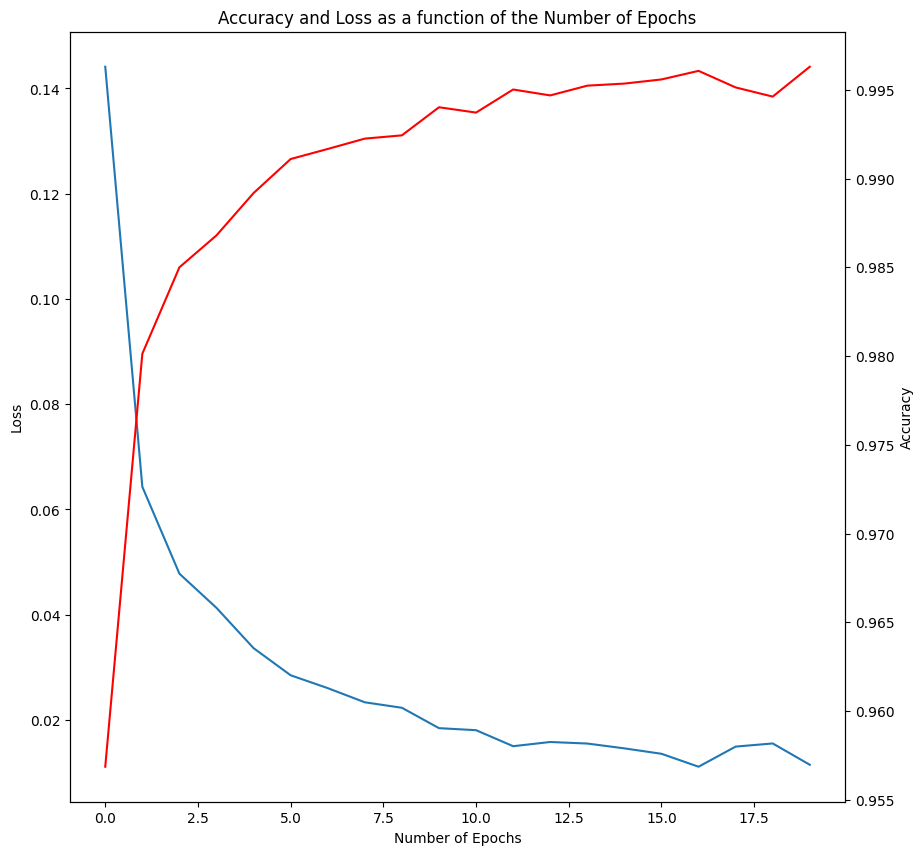

In [66]:
#Plot Accuracy and Loss Trends across training 
fig, ax = plt.subplots(figsize = (10,10))
sns.lineplot(x = range(len(history.history['loss'])), y = history.history['loss'], ax = ax)
ax.set(xlabel = 'Number of Epochs', ylabel = 'Loss', title = 'Accuracy and Loss as a function of the Number of Epochs')

ax2 = ax.twinx()
sns.lineplot(x = range(len(history.history['accuracy'])), y = history.history['accuracy'], color = 'r', ax = ax2)
ax2.set(ylabel = 'Accuracy')

In [67]:
# Score
score = model.evaluate(X_test, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9855 - loss: 0.0495
